# **Record Classifier on SIVEP-GRIPE**

**Author**: Higor S. Monteiro<br>
**Date**: 17 August 2023<br>

**Objective**:<br> 
Create a machine learning classifier to identify whether two records refers to a same person in SIVEP-GRIPE.

**Context**:<br> 
DATASUS provides several different information systems with the goal to digitally support the infrastructure of the Brazilian Universal Health System (SUS). Within the systems available, notification of occurrences is done in specific systems, such as SINASC (birth), SIM (death), SINAN (some ICD-10 codes) or SIVEP-GRIPE (SARI). Despite the use of these systems across the country, the databases rarely communicate between themselves through a unique primary key. 

In some cases, there is the possibility of obtaining CPF and CNS (two personal and unique information codes) within some of those systems, but even so they are not filled consistently across databases. Thus, individual identification, in most of the cases, is only possible by using sensitive personal information. Nevertheless, personal information is filled manually and there is a high occurrence of different typos in those fields. Thus, naive linkage and deduplication procedures lead to several records without proper linking. Following this rationale, a probabilistic approach taking into account the possibility of mispelling is necessary in order to improve the data matching process closer to 80-100%.

Even with implementation of such methodology, we stress that rule-based approaches for the classification step still require a substantial amount of manual processing for harder cases of pairs. Rule-based approaches are simple and adequate for extreme cases (easy positive and negative pairs of records), but they are not suitable for harder cases, where similarity between a given pair is neither low or high enough for easy classification. In such cases, human classification is usually necessary. Such methodology can generate a crucial dataset that is very useful for supervising learning.

**Methodology**:<br>
We used a set of classified pairs of SIVEP-GRIPE records to create a machine learning model able to classify whether two records refer to the same individual. The dataset of classified pairs are resulted from a probabilistic deduplication process with human classification for intermediate and harder cases, while a rule-based approach was used for the easier cases. We created three different models: Logistic Regression, Random Forest and Gradient Boosting. In such models, it is possible to assess not only the final classification but also the probabilities for each class (positive and negative). Such uncertainty information allows us to provide more reliable classifications. These models will be included for automatic consolidation of weekly new SIVEP-GRIPE data. 



# **Bib**

In [134]:
import os
import glob
import ujson as json
from joblib import dump
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
# -- models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# -- evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Prepare Training Data** 

**Load the similarity matrix**<br>

This matrix is generated using approximated blocking over the 'FONETICA_N' field, defined as the patient's first and last name concatenated.<br> 
String comparison was performed using the 'damerau_levenstein' similarity algorithm. 

In [101]:
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data", "SIVEP-GRIPE")

In [102]:
similarity_matrix = pd.read_parquet(os.path.join(basepath, 'TRAINING_DATA_CLASSIFIER', "DEDUPE_FILES", "feature_pairs.parquet"))
print(similarity_matrix.info())
similarity_matrix.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3164107 entries, ('315903192836', '316140034555') to ('31643139501218', '31642879031856')
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   cns                     int64  
 1   cep                     int64  
 2   cpf                     int64  
 3   sexo                    int64  
 4   nascimento_dia          int64  
 5   nascimento_mes          int64  
 6   nascimento_ano          int64  
 7   primeiro_nome_mae       float64
 8   complemento_nome_mae    float64
 9   primeiro_nome           float64
 10  complemento_nome        float64
 11  bairro                  float64
 12  rank_primeiro_nome      int32  
 13  rank_primeiro_nome_mae  float64
dtypes: float64(6), int32(1), int64(7)
memory usage: 355.0+ MB
None


,,cns,cep,cpf,sexo,nascimento_dia,nascimento_mes,nascimento_ano,primeiro_nome_mae,complemento_nome_mae,primeiro_nome,complemento_nome,bairro,rank_primeiro_nome,rank_primeiro_nome_mae
ID_SIVEP_1,ID_SIVEP_2,,,,,,,,,,,,,,
315983733440,316123859391,0,0,0,1,0,1,0,0.000000,0.0,1.0,0.0,0.0,7,4.0
315955972474,316274002437,0,0,0,1,0,0,0,0.000000,0.0,1.0,0.0,0.0,7,6.0
316232675992,315904276980,0,0,0,1,0,0,0,1.000000,0.0,1.0,0.0,0.0,6,7.0
315902569088,316267990980,0,0,0,1,0,0,0,0.000000,0.0,1.0,0.0,0.0,7,6.0
31666028691379,315958804923,0,0,0,1,0,0,0,0.714286,0.0,1.0,0.0,0.0,7,4.0


In [103]:
similarity_matrix["rank_primeiro_nome_mae"] = similarity_matrix["rank_primeiro_nome_mae"].apply(lambda x: int(x) if pd.notna(x) else 0)

In [104]:
similarity_matrix["FMT_PKEY"] = [ f"{n[0]}-{n[1]}" for n in similarity_matrix.index ]

**Load classified pairs**

In [105]:
pair_folders = ["HIGH_PAIRS", "MIDHIGH_PAIRS", "MID_PAIRS", "MIDLOW_PAIRS", "LOW_PAIRS"]

pairs_lst = []
for current_folder in pair_folders:
    file_lst = glob.glob(os.path.join(basepath, 'TRAINING_DATA_CLASSIFIER', "DEDUPE_FILES", current_folder, "*"))
    
    for fname in file_lst:
        with open(fname, "r") as f:
            pairs_lst += json.load(f)['pairs']

Select the pairs with classification

In [106]:
clas_pairs = [ pair for pair in pairs_lst if pair['classification']!='' and pair['classification']!='potential' ]
left_ids = [ pair['identifiers']['a'] for pair in clas_pairs ]
right_ids = [ pair['identifiers']['b'] for pair in clas_pairs ]
labels = [ pair['classification'] for pair in clas_pairs ]
feature_sum_pos = [ pair['agg']['S'] for pair in clas_pairs if pair['classification']=='positive' ]
feature_sum_neg = [ pair['agg']['S'] for pair in clas_pairs if pair['classification']=='negative' ]

print(f"Labeled pairs: {len(labels)}")

Labeled pairs: 4013


**Label distribution per sum of features**

Text(0.5, 1.0, 'Label per feature sum')

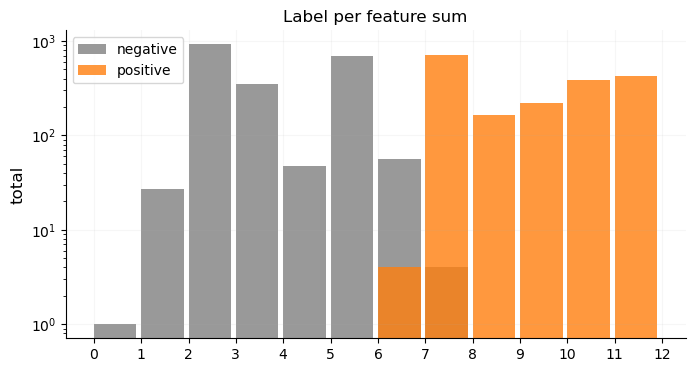

In [107]:
freq_soma_pos, interval_soma_pos = np.histogram(feature_sum_pos, bins=np.arange(0, 13.0, 1.0))
freq_soma_neg, interval_soma_neg = np.histogram(feature_sum_neg, bins=np.arange(0, 13.0, 1.0))

fig, ax = plt.subplots(1, figsize=(8,4))
ax.bar(interval_soma_neg[:-1], freq_soma_neg, align='edge', width=0.9, color='gray', alpha=0.8, label="negative")
ax.bar(interval_soma_pos[:-1], freq_soma_pos, align='edge', width=0.9, color='tab:orange', alpha=0.8, label="positive")

for axis in [ax]:
    axis.grid(alpha=0.1)
    axis.set_xticks(np.arange(0, 13.0, 1.0))
    axis.set_ylabel("total", fontsize=12)
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.set_yscale('log')
    axis.legend()
ax.set_title("Label per feature sum")

**Format training set** 

In [108]:
class_df = pd.DataFrame({"ID_SIVEP_1": left_ids, "ID_SIVEP_2": right_ids, "LABEL": labels})
class_df["FMT_PKEY"] = class_df["ID_SIVEP_1"] + "-" + class_df["ID_SIVEP_2"]
class_df = class_df.drop(["ID_SIVEP_1", "ID_SIVEP_2"], axis=1)
class_df["LABEL"] = class_df["LABEL"].map({"positive": 1, "negative": 0})
class_df.sample(n=5)

,LABEL,FMT_PKEY
3556,0,31645476988434-316250825558
1896,1,31647966909397-31651491664634
2047,0,31642720321998-316183405188
1247,1,315837634681-315991356449
1470,1,316079503410-316097775512


In [109]:
training_df = similarity_matrix.reset_index().merge(class_df, on="FMT_PKEY", how="inner").set_index(["ID_SIVEP_1", "ID_SIVEP_2"]).drop("FMT_PKEY", axis=1)

In [110]:
training_df

cns  cep  cpf  sexo  nascimento_dia  \
ID_SIVEP_1     ID_SIVEP_2                                            
316159190773   316164383111      0    0    0     1               0   
316184282645   31642876784205    0    0    0     1               0   
31645476988434 316250825558      0    0    0     1               0   
316013209350   316063988014      0    0    0     1               0   
316281751153   316294662693      0    0    0     1               0   
...                            ...  ...  ...   ...             ...   
316210188910   316242869913      0    0    0     1               0   
31664095368205 31656937149818    0    0    0     1               1   
               31665461190004    0    0    0     1               1   
315880883485   315901573538      0    0    0     1               0   
315931903237   316311899186      0    0    0     1               0   

                               nascimento_mes  nascimento_ano  \
ID_SIVEP_1     ID_SIVEP_2                                       
316159190773   316164383111                 0               0   
316184282645   31642876784205               0               0   
31645476988434 316250825558                 0               0   
316013209350   316063988014                 0               0   
316281751153   316294662693                 0               0   
...                                       ...             ...   
316210188910   316242869913                 0               0   
31664095368205 31656937149818               1               1   
               31665461190004               1               1   
315880883485   315901573538                 0               0   
315931903237   316311899186                 0               0   

                               primeiro_nome_mae  complemento_nome_mae  \
ID_SIVEP_1     ID_SIVEP_2                                                
316159190773   316164383111                  0.0                   0.0   
316184282645   31642876784205                0.6                   0.0   
31645476988434 316250825558                  1.0                   0.0   
316013209350   316063988014                  0.0                   0.0   
316281751153   316294662693                  0.0                   0.0   
...                                          ...                   ...   
316210188910   316242869913                  0.0                   0.0   
31664095368205 31656937149818                1.0                   1.0   
               31665461190004                1.0                   1.0   
315880883485   315901573538                  0.0                   0.0   
315931903237   316311899186                  0.0                   0.0   

                               primeiro_nome  complemento_nome  bairro  \
ID_SIVEP_1     ID_SIVEP_2                                                
316159190773   316164383111              1.0          0.000000     0.0   
316184282645   31642876784205            1.0          0.000000     0.0   
31645476988434 316250825558              1.0          0.000000     0.0   
316013209350   316063988014              1.0          0.000000     0.0   
316281751153   316294662693              1.0          0.000000     0.0   
...                                      ...               ...     ...   
316210188910   316242869913              1.0          0.000000     0.0   
31664095368205 31656937149818            1.0          0.961538     0.0   
               31665461190004            1.0          0.923077     0.0   
315880883485   315901573538              1.0          0.000000     0.0   
315931903237   316311899186              1.0          0.000000     0.0   

                               rank_primeiro_nome  rank_primeiro_nome_mae  \
ID_SIVEP_1     ID_SIVEP_2                                                   
316159190773   316164383111                     7                       4   
316184282645   31642876784205                   7                       7   
31645476988434 316250825558             

# **Model Training**

In [111]:
training_data = training_df.copy()

X, y = training_data.iloc[:,:-1].values, training_data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## **Model:** Gradient Boosting Classifier

In [112]:
gbt_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.2, warm_start=True)
gbt_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, warm_start=True)

**Choose number of estimators based on MSE error**

In [113]:
mse_errors = [mean_squared_error(y_train, y_pred) for y_pred in gbt_model.staged_predict(X_train)]

accuracy_errors = [accuracy_score(y_train, y_pred) for y_pred in gbt_model.staged_predict(X_train)]
precision_errors = [precision_score(y_train, y_pred) for y_pred in gbt_model.staged_predict(X_train)]
recall_errors = [recall_score(y_train, y_pred) for y_pred in gbt_model.staged_predict(X_train)]
f1_errors = [f1_score(y_train, y_pred) for y_pred in gbt_model.staged_predict(X_train)]

bst_n_estimators_mse = np.argmin(mse_errors) + 1

Optimal number of estimators: 68


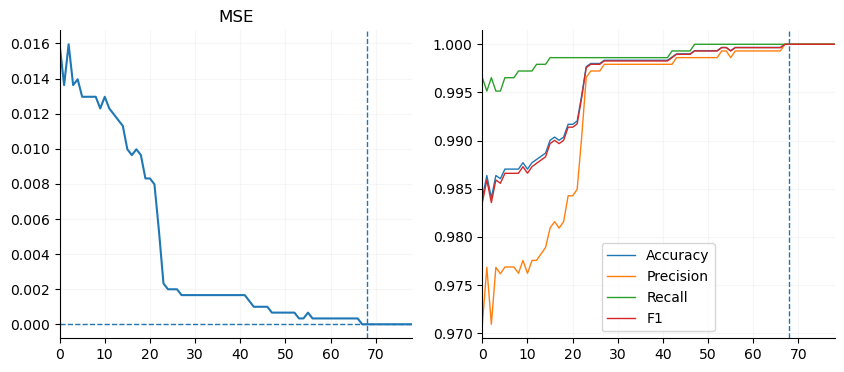

In [114]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.))

ax1.plot(mse_errors)
ax2.plot(accuracy_errors, lw=1, label="Accuracy")
ax2.plot(precision_errors, lw=1, label="Precision")
ax2.plot(recall_errors, lw=1, label="Recall")
ax2.plot(f1_errors, lw=1, label="F1")
ax1.axhline(y=np.min(mse_errors), xmin=0, xmax=100, ls="--", lw=1)

print(f"Optimal number of estimators: {bst_n_estimators_mse}")
ax2.legend()
ax1.set_title("MSE")
for axis in [ax1, ax2]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.grid(alpha=0.1)
    axis.set_xlim([0,bst_n_estimators_mse+10])
    axis.axvline(x=bst_n_estimators_mse, ymin=0, ymax=1, ls="--", lw=1)

In [115]:
gbt_model = GradientBoostingClassifier(n_estimators=bst_n_estimators_mse+1, max_depth=3, learning_rate=0.2, warm_start=True)
gbt_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=69, warm_start=True)

**Confusion matrix on training and test data**

Text(0.5, 1.0, 'On test set')

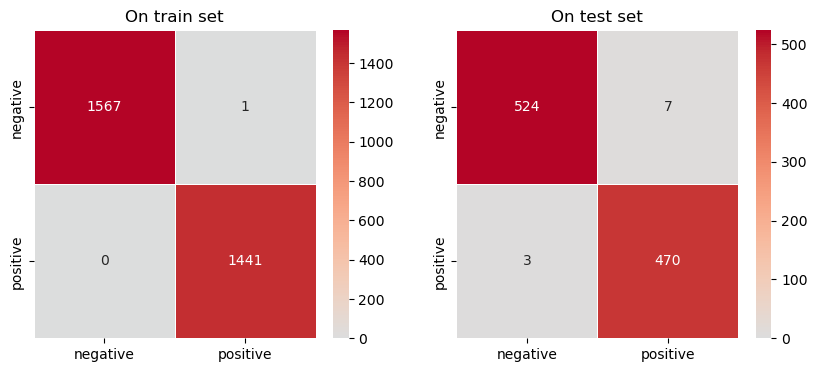

In [116]:
cm_train = confusion_matrix(y_train, gbt_model.predict(X_train))
cm_test = confusion_matrix(y_test, gbt_model.predict(X_test))

cm_train = pd.DataFrame(cm_train, columns=["negative", "positive"], index=['negative', 'positive'])
cm_test = pd.DataFrame(cm_test, columns=["negative", "positive"], index=['negative', 'positive'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_train, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax1, cmap="coolwarm")
sns.heatmap(cm_test, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax2, cmap="coolwarm")

ax1.set_title("On train set")
ax2.set_title("On test set")

In [117]:
scores = cross_val_score(gbt_model, X_test, y_test, scoring="precision", cv=10)
scores

array([0.97959184, 1.        , 0.94      , 0.97916667, 0.9787234 ,
       1.        , 1.        , 1.        , 0.94      , 0.95918367])

**Train the model with the whole data**

In [118]:
gbt_final = GradientBoostingClassifier(n_estimators=bst_n_estimators_mse+1, max_depth=3, learning_rate=0.2, warm_start=True)
gbt_final.fit(X, y)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=69, warm_start=True)

## **Model:** Random Forest

In [119]:
rnf_model = RandomForestClassifier(n_estimators=300, max_depth=5, max_samples=1000, oob_score=True)
rnf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_samples=1000, n_estimators=300,
                       oob_score=True)

In [120]:
list(zip(list(training_data.columns[:-1]), rnf_model.feature_importances_))

[('cns', 0.003950188645402696),
 ('cep', 0.008032292188315113),
 ('cpf', 0.015040547114041418),
 ('sexo', 0.0004023634331291894),
 ('nascimento_dia', 0.1335644601027452),
 ('nascimento_mes', 0.05867598674572576),
 ('nascimento_ano', 0.1897729603934526),
 ('primeiro_nome_mae', 0.025806717083481742),
 ('complemento_nome_mae', 0.1537340099617775),
 ('primeiro_nome', 4.04900607266708e-09),
 ('complemento_nome', 0.33053960918544123),
 ('bairro', 0.05376601080486991),
 ('rank_primeiro_nome', 0.016097238656184624),
 ('rank_primeiro_nome_mae', 0.010617611636427177)]

**Confusion matrix on training and test data**

Text(0.5, 1.0, 'On test set')

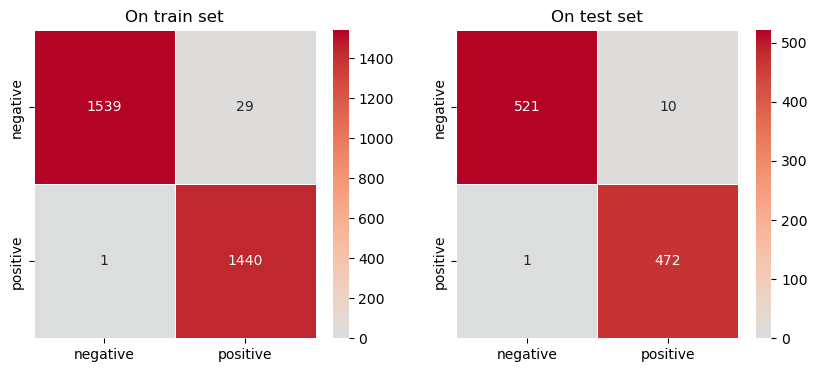

In [122]:
cm_train = confusion_matrix(y_train, rnf_model.predict(X_train))
cm_test = confusion_matrix(y_test, rnf_model.predict(X_test))

cm_train = pd.DataFrame(cm_train, columns=["negative", "positive"], index=['negative', 'positive'])
cm_test = pd.DataFrame(cm_test, columns=["negative", "positive"], index=['negative', 'positive'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_train, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax1, cmap="coolwarm")
sns.heatmap(cm_test, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax2, cmap="coolwarm")

ax1.set_title("On train set")
ax2.set_title("On test set")

In [123]:
scores = cross_val_score(rnf_model, X, y, scoring="precision", cv=10)
scores

array([0.99479167, 1.        , 0.98963731, 0.99479167, 0.99479167,
       0.99479167, 0.98453608, 0.98453608, 0.97938144, 0.88479263])

## **Model:** Logistic Regression

In [128]:
# L1 Regression
logit_models = [ (LogisticRegression(C=lbda, penalty="l1", solver="liblinear", max_iter=100), lbda) for lbda in np.arange(0.5, 6.0, 0.5) ]

precision_scores_l1 = []
for cur_inst in logit_models:
    cur_model, cur_lbda = cur_inst[0], cur_inst[1]
    score = cross_val_score(cur_model, X, y, scoring="precision", cv=10).mean()
    precision_scores_l1.append((cur_lbda, score))

In [127]:
# L2 Regression
logit_models = [ (LogisticRegression(C=lbda, penalty="l2", max_iter=200, verbose=0), lbda) for lbda in np.arange(0.5, 6.0, 0.5) ]

precision_scores_l2 = []
for cur_inst in logit_models:
    cur_model, cur_lbda = cur_inst[0], cur_inst[1]
    score = cross_val_score(cur_model, X, y, scoring="precision", cv=10).mean()
    precision_scores_l2.append((cur_lbda, score))

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_12496\804533613.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f"{x:0.4f}" for x in ax1.get_yticks()], rotation=-10)
C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_12496\804533613.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f"{x:0.4f}" for x in ax2.get_yticks()], rotation=-10)


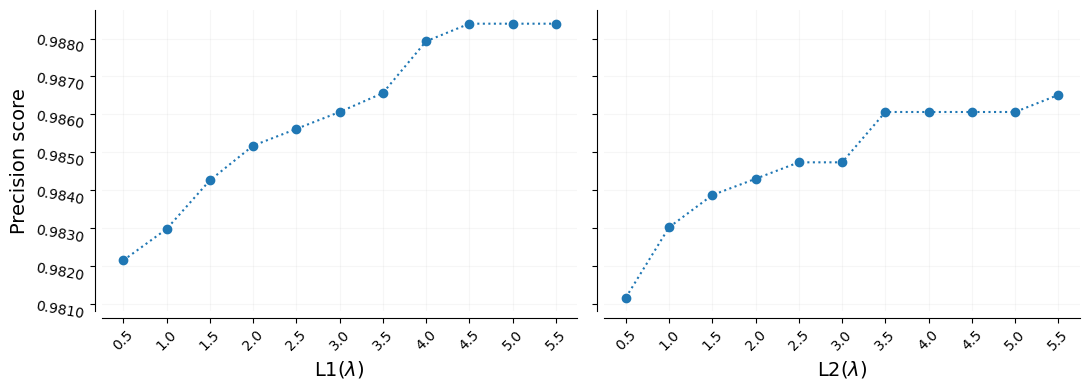

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), sharey=True)
for axis in [ax1, ax2]:
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.grid(alpha=0.1)
    axis.spines['left'].set_position(('outward', 5))
    axis.spines['bottom'].set_position(('outward', 5))
    axis.tick_params(direction="out")
    axis.set_xticks(np.arange(0.5, 6.0, 0.5))
    axis.set_xticklabels([f"{x}" for x in np.arange(0.5, 6.0, 0.5)], rotation=45)

ax1.plot([x[0] for x in precision_scores_l1], [x[1] for x in precision_scores_l1], marker="o", ls=":")
ax2.plot([x[0] for x in precision_scores_l2], [x[1] for x in precision_scores_l2], marker="o", ls=":")
ax1.set_xlabel(r"L1($\lambda$)", fontsize=14)
ax2.set_xlabel(r"L2($\lambda$)", fontsize=14)
ax1.set_ylabel(r"Precision score", fontsize=14)

ax1.set_yticklabels([f"{x:0.4f}" for x in ax1.get_yticks()], rotation=-10)
ax2.set_yticklabels([f"{x:0.4f}" for x in ax2.get_yticks()], rotation=-10)


plt.tight_layout()

In [131]:
lgt_model = LogisticRegression(C=3.5, penalty="l2")
lgt_model.fit(X_train, y_train)

C:\Users\higor.monteiro\Miniconda3\envs\cevepi\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=3.5)

**Confusion matrix on training and test data**

Text(0.5, 1.0, 'On test set')

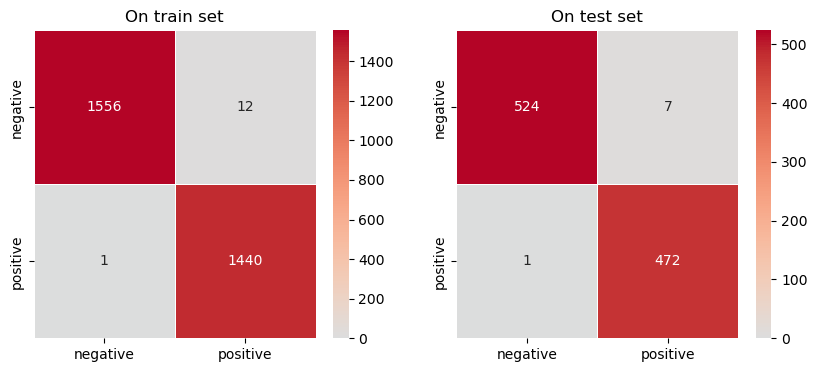

In [132]:
cm_train = confusion_matrix(y_train, lgt_model.predict(X_train))
cm_test = confusion_matrix(y_test, lgt_model.predict(X_test))

cm_train = pd.DataFrame(cm_train, columns=["negative", "positive"], index=['negative', 'positive'])
cm_test = pd.DataFrame(cm_test, columns=["negative", "positive"], index=['negative', 'positive'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_train, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax1, cmap="coolwarm")
sns.heatmap(cm_test, center=True, vmin=0, annot=True, fmt=".0f", linewidth=0.5, ax=ax2, cmap="coolwarm")

ax1.set_title("On train set")
ax2.set_title("On test set")

**Train the model with the whole data**

In [133]:
lgt_model = LogisticRegression(C=3.5, penalty="l2")
lgt_model.fit(X, y)

C:\Users\higor.monteiro\Miniconda3\envs\cevepi\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=3.5)

## **Persist the models**

In [135]:
dump(gbt_model, os.path.join(basepath, "TRAINED_MODELS", "GRADBOOST_SIVEP04SET2023.joblib"))
dump(rnf_model, os.path.join(basepath, "TRAINED_MODELS", "RANDFOREST_SIVEP04SET2023.joblib"))
dump(lgt_model, os.path.join(basepath, "TRAINED_MODELS", "LOGITREG_SIVEP04SET2023.joblib"))

['\\Users\\higor.monteiro\\Documents\\data\\SIVEP-GRIPE\\TRAINED_MODELS\\LOGITREG_SIVEP04SET2023.joblib']